### Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount(mountpoint='/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from datetime import datetime
from IPython.display import display
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import style
from tqdm import tqdm

In [4]:
from skimage.util.shape import view_as_blocks
from sklearn.model_selection import train_test_split

In [5]:
import os
import re

In [6]:
import cv2 as cv
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [7]:
style.use(style='seaborn-deep')

### Images and labels

In [11]:
tr_path = "/content/dataset/train"
te_path = "/content/dataset/test"

In [12]:
tr_images = glob(pathname=(tr_path + '/*jpeg'))
te_images = glob(pathname=(te_path + '/*jpeg'))

In [13]:
tr_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), tr_images))
te_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), te_images))

In [14]:
(tr_images,
 cv_images,
 tr_labels,
 cv_labels) = train_test_split(tr_images, tr_labels, test_size=0.20, random_state=0)

In [15]:
print(len(tr_images), len(tr_labels))
print(len(cv_images), len(cv_labels))

64000 64000
16000 16000


### Preprocessing

Preprocess a single image for visualization

In [16]:
def preprocess_input_image(imagefile, resize_scale=(200, 200)):
    """
    This function preprocesses in the input image.
    """
    rows, cols = (8, 8)
    img = cv.imread(filename=imagefile)
    img = cv.resize(src=img, dsize=resize_scale)
    h, w, c = img.shape
    square = h // rows # 200 // 8 = 50
    # Below line of code returns an image in blocks. Shape: (8, 8, 1, 25, 25, 3).
    img_blocks = view_as_blocks(arr_in=img, block_shape=(square, square, c))
    # Below line of code reshapes the image blocks. Shape: (64, 25, 25, 3).
    # In a chessboard, there are 64 squares and each square is of shape (25, 25, 3).
    img_blocks = img_blocks.reshape(rows * cols, square, square, c)
    return img_blocks

In [17]:
def visualize_preprocessed_image(imagefile):
    """
    This function is for better understanding the preprocessing step.
    """
    c = 8
    r = 8

    img = cv.imread(filename=imagefile)

    print("Input: Chess image\n")
    plt.figure(figsize=(r, c))
    plt.imshow(X=img)
    plt.axis('off')
    plt.show()

    img_blocks = preprocess_input_image(imagefile=imagefile)
    fig = plt.figure(figsize=(r, c))
    print("\nPreprocessed: Chess image broken into 64 squares\n")
    for i, img_block in enumerate(img_blocks):
        fig.add_subplot(r, c, i+1)
        plt.imshow(X=img_block)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

Input: Chess image



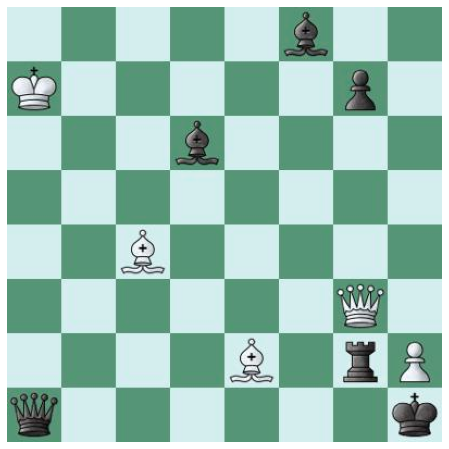


Preprocessed: Chess image broken into 64 squares



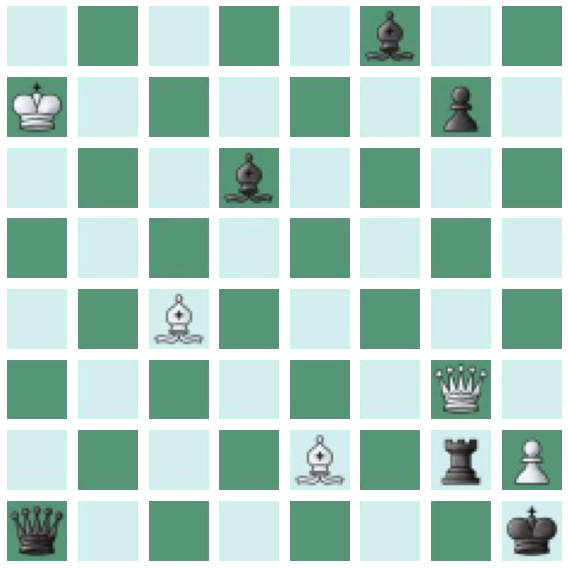

In [18]:
imagefile = random.choice(seq=tr_images)
visualize_preprocessed_image(imagefile=imagefile)

In [19]:
import tensorflow as tf

In [20]:
from tensorflow.keras.layers import (
    Conv2D,
    Flatten, 
    Dense, 
    Dropout,
    Input
)

from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    Callback
)

from tensorflow.keras.models import Model

In [21]:
class DataPipeline(object):
    """
    This class is a data pipeline for deep learning model.
    """

    def __init__(self, tr_images, tr_labels, cv_images, cv_labels, te_images, te_labels):
        self.rows, self.cols = (8, 8)
        self.square = None
        self.h, self.w, self.c = None, None, None
        self.N = 13
        self.tr_images = np.array(tr_images)
        self.tr_labels = np.array(tr_labels)
        self.cv_images = np.array(cv_images)
        self.cv_labels = np.array(cv_labels)
        self.te_images = np.array(te_images)
        self.te_labels = np.array(te_labels)
        self.piece_symbols = 'prbnkqPRBNKQ'
    
    def preprocess_input_image(self, imagefile, resize_scale=(200, 200)):
        """
        This function preprocesses in the input image.
        """
        img = cv.imread(filename=imagefile)
        img = cv.resize(src=img, dsize=resize_scale)
        self.h, self.w, self.c = img.shape
        self.square = self.h // self.rows
        img_blocks = view_as_blocks(
            arr_in=img, block_shape=(self.square, self.square, self.c))
        img_blocks = img_blocks.reshape(
            self.rows * self.cols, self.square, self.square, self.c)
        return img_blocks
    
    def tr_data_generator(self):
        """
        This method preprocess the input images.
        """
        for i, l in zip(self.tr_images, self.tr_labels):
            yield (self.preprocess_input_image(imagefile=i),
                   self.onehot_from_fen(fen=l))
    
    def cv_data_generator(self):
        """
        This method preprocess the input images.
        """
        for i, l in zip(self.cv_images, self.cv_labels):
            yield (self.preprocess_input_image(imagefile=i),
                   self.onehot_from_fen(fen=l))
    
    def te_data_generator(self):
        """
        This method preprocess the input targets.
        """
        for i in self.te_images:
            yield self.preprocess_input_image(imagefile=i)
    
    def onehot_from_fen(self, fen):
        """
        This function converts FEN to onehot.
        The original author of this method is 'PAVEL KORYAKIN'.
        PAVEL KORYAKIN is also the maintainer of Chess Positions dataset.
        """
        eye = np.eye(N=self.N)
        output = np.empty(shape=(0, self.N))
        fen = re.sub(pattern='[/]', repl='', string=fen)
        for char in fen:
            if char in '12345678':
                output = np.append(
                    arr=output, values=np.tile(A=eye[self.N-1], reps=(int(char), 1)), axis=0)
            else:
                idx = self.piece_symbols.index(char)
                output = np.append(
                    arr=output, values=eye[idx].reshape((1, self.N)), axis=0)
        return output
    
    def fen_from_onehot(self, onehot):
        """
        This function converts onehot to FEN.
        The original author of this method is 'PAVEL KORYAKIN'.
        PAVEL KORYAKIN is also the maintainer of Chess Positions dataset.
        """
        output = str()
        for j in range(self.rows):
            for i in range(self.cols):
                if onehot[j][i] == 12:
                    output += ' '
                else:
                    output += self.piece_symbols[int(onehot[j][i])]
            if j != 7:
                output += '/'
        for i in range(8, 0, -1):
            output = output.replace(' ' * i, str(i))
        return output
    
    def construct_dataset(self):
        """
        This method constructs the dataset.
        """
        tr_dataset = tf.data.Dataset.from_generator(
            generator=self.tr_data_generator, output_types=(tf.int64, tf.int64))
        tr_dataset = tr_dataset.repeat()
        cv_dataset = tf.data.Dataset.from_generator(
            generator=self.cv_data_generator, output_types=(tf.int64, tf.int64))
        cv_dataset = cv_dataset.repeat()
        te_dataset = tf.data.Dataset.from_generator(
            generator=self.te_data_generator, output_types=tf.int64)
        te_dataset = te_dataset.repeat()
        it_tr = tr_dataset.__iter__()
        it_cv = cv_dataset.__iter__()
        it_te = te_dataset.__iter__()
        return it_tr, it_cv, it_te

In [22]:
def plot_model_performance(tracker, epochs):
    """
    This function plots the performance of the model.
    """
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(range(1, epochs+1), tracker.history['accuracy'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_accuracy'], 'g--', label='validation')
    plt.title('Accuracy Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(132)
    plt.plot(range(1, epochs+1), tracker.history['loss'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_loss'], 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.show()

In [23]:
data_pipe = DataPipeline(tr_images=tr_images,
                         tr_labels=tr_labels,
                         cv_images=cv_images,
                         cv_labels=cv_labels,
                         te_images=te_images,
                         te_labels=te_labels)

In [24]:
tr_dataset, cv_dataset, te_dataset = data_pipe.construct_dataset()

In [25]:
input_shape = (25, 25, 3)
batch_size = 64
steps_per_epoch = len(tr_images) // batch_size
validation_steps = len(cv_images) // batch_size
test_steps = len(te_images) // batch_size
output_units = 13 # Because I have 12 chess pieces and 1 for all digits

In [26]:
input_layer = Input(shape=input_shape, batch_size=batch_size, name='Input')
conv_2d_layer_1 = Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_1')(input_layer)
conv_2d_layer_2 = Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_2')(conv_2d_layer_1)
flatten_layer = Flatten(name='Flatten')(conv_2d_layer_2)
dense_layer = Dense(units=64, activation='relu', name='Dense')(flatten_layer)
output_layer = Dense(units=output_units, activation='softmax', name='Output')(dense_layer)

In [27]:
model = Model(inputs=input_layer, outputs=output_layer, name='Base_Model')
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
filepath = "/content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/base_model.h5"
model_save_callback = ModelCheckpoint(
    filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks = [model_save_callback]

In [29]:
model.summary()

Model: "Base_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(64, 25, 25, 3)]         0         
                                                                 
 Conv2D_1 (Conv2D)           (64, 23, 23, 32)          896       
                                                                 
 Conv2D_2 (Conv2D)           (64, 21, 21, 32)          9248      
                                                                 
 Flatten (Flatten)           (64, 14112)               0         
                                                                 
 Dense (Dense)               (64, 64)                  903232    
                                                                 
 Output (Dense)              (64, 13)                  845       
                                                                 
Total params: 914,221
Trainable params: 914,221
Non-trai

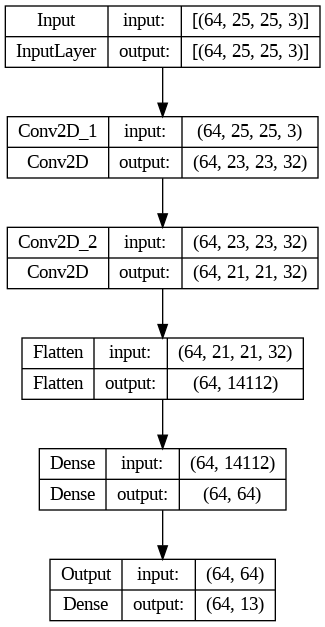

In [30]:
tf.keras.utils.plot_model(model=model,
                          to_file='base_model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          expand_nested=False)

In [31]:
epochs = 5
tracker = model.fit(x=tr_dataset,
                    validation_data=cv_dataset,
                    epochs=epochs,
                    steps_per_epoch=len(tr_images),
                    validation_steps=len(cv_images),
                    callbacks=callbacks)

Epoch 1/5
63993/64000 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9926
Epoch 1: val_accuracy improved from -inf to 0.99843, saving model to /content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/base_model.h5
64000/64000 [==============================] - 407s 6ms/step - loss: 0.0668 - accuracy: 0.9926 - val_loss: 0.0092 - val_accuracy: 0.9984
Epoch 2/5
63996/64000 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9990
Epoch 2: val_accuracy improved from 0.99843 to 0.99944, saving model to /content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/base_model.h5
64000/64000 [==============================] - 402s 6ms/step - loss: 0.0150 - accuracy: 0.9990 - val_loss: 0.0143 - val_accuracy: 0.9994
Epoch 3/5
63999/64000 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9994
Epoch 3: val_accuracy improved from 0.99944 to 0.99962, saving model to /content/drive/MyDrive/Applied-AI/Case-Study-2/model_save/base_model.h5


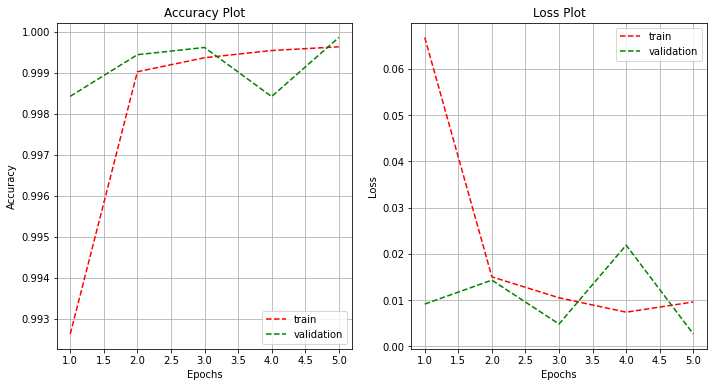

In [32]:
plot_model_performance(tracker=tracker, epochs=epochs)

In [33]:
result = model.predict(x=te_dataset, steps=len(te_images))

20000/20000 [==============================] - 92s 5ms/step


In [34]:
result = result.argmax(axis=1)
result = result.reshape(-1, 8, 8)

In [35]:
pr_labels = list(map(data_pipe.fen_from_onehot, result))

In [39]:
te_labels, pr_labels = np.array(te_labels), np.array(pr_labels)

In [41]:
base_model_acc = (te_labels == pr_labels).astype(float).mean() * 100
print(f"Base model accuracy: {round(base_model_acc, 3)}%")

Base model accuracy: 99.31%
